# Model

## Techniques
* Keras
* Data Augmentation
* Bottleneck Feature


## Problem
Image Classification <br/>
    * Macroinvertebrates
        * Identify 7 families of macroinvertebrates


## Calling Inception-v3 with ImageNet weigths.

In [1]:
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
import h5py

from random import shuffle
from PIL import Image
import os
import numpy as np
import pickle

# Logging settings
import logging
import sys
logging.basicConfig(filename='report.log', format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG)
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout

# Default dimension 299x299
DIM = 299
CLASSES = 10



Using TensorFlow backend.


In [2]:
# InceptionV3 model with imagenet weights, no top and not trainable setting
base_model = InceptionV3(input_shape=(DIM, DIM, 3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False

# Adding extra top layers

# In this case we use GlobalAveragePooling2D instead of flatten for complexity reduction
# Convert model output -> batchx8x8x2048 into batchx2048
# With flatten it'll be 64 times bigger

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(CLASSES, activation='softmax')(x)


# Concatenating model with our custom top
model = Model(base_model.input, predictions)
print(model.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 149, 149, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 149, 149, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 149, 149, 32)  0           batch_normalization_1[0][0]      
___________________________________________________________________________________________

## Basic Data Loading Module

In [3]:
from skimage import img_as_float
from skimage import img_as_ubyte

class LocalDataLoader:
    
    def __init__(self, img_dim, raw_dir = './data/', dset_dir = './dataset/', nb_per_class=20, val_ratio=0.3, test_ratio=0.1):
        self.raw_dir = raw_dir
        self.dset_dir = dset_dir
        self.img_dim = img_dim
        self.img_dim_str = '{}x{}'.format(img_dim[0], img_dim[1])
        self.nb_per_class = nb_per_class
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        
        self.dataset_name = '{}_{}'.format(self.nb_per_class, self.img_dim_str)
        
    def load_data(self):
        dataset_file_dir = "{}dataset_{}.h5".format(self.dset_dir, self.dataset_name)
        if not os.path.isfile(dataset_file_dir):
            print("Dataset not found.")
            print("Creating dataset ...")
            self.create_dataset()
        else:
            print("Using existing dataset.")
            
        h5f = h5py.File(dataset_file_dir,'r')
        train_X = h5f['train_X'][:]
        train_y = h5f['train_y'][:]
        validation_X = h5f['validation_X'][:]
        validation_y = h5f['validation_y'][:]
        h5f.close()
        
        #train_X = pickle.load(open("{}train_X_{}.p".format(self.dset_dir, self.dataset_name), "rb"))
        #train_y = pickle.load(open("{}train_y_{}.p".format(self.dset_dir, self.dataset_name), "rb"))
        #validation_X = pickle.load(open("{}validation_X_{}.p".format(self.dset_dir, self.dataset_name), "rb"))
        #validation_y = pickle.load(open("{}validation_y_{}.p".format(self.dset_dir, self.dataset_name), "rb"))
        print("Dataset loaded!")
        return train_X, train_y, validation_X, validation_y
        
    def create_dataset(self):        
        class_names = os.listdir(self.raw_dir)
        
        # checking dir size        
        def directory_files_filter(class_name, len_limit=2):
            l = len(os.listdir(self.raw_dir + class_name + '/'))           
            if l * self.test_ratio > len_limit and l * self.val_ratio > len_limit:
                return True
            else:
                print("{} too few images. only {}".format(class_name, l))
            return False
        
        print("Filtering...")
        class_names = list(filter(lambda x: directory_files_filter(x), class_names)) 
        print(class_names)
        
        train_X = []
        train_y = []
        validation_X = []
        validation_y = []
        test_X = []
        test_y = []
        
        for i, class_name in enumerate(class_names):
            class_dir = self.raw_dir + class_name + '/'
            
            files = os.listdir(class_dir)
            
            # Important to shuffle the files on the directory
            shuffle(files)
            
            print(class_name)
            x = []
      
            # Inside class directory
            for j, file in enumerate(files):
                file_dir = class_dir + file
                
                if j%50 == 0:
                    print("Processing file {} of {}".format(j, len(files)))              
                try:
                    img = Image.open(file_dir)
                except:
                    print("Unable to open {} ... skipping file.".format(file))
                    pass
                
                img = img.convert('RGB')
                img = img.resize(self.img_dim, resample=Image.ANTIALIAS)
                imgData = np.asarray(img, dtype=np.uint8)                
                
                x.append(imgData)
                #class_data.append((imgData, label))
                

            # Split data flags
            validation_nb = int(len(x) * self.val_ratio)
            test_nb = int(len(x) * self.test_ratio)
            train_nb = len(x) - (validation_nb + test_nb)
            
            print('validation',validation_nb)
            print('test',test_nb)
            print('train',train_nb)

            # Splitting the data
            reshape_dim = [-1, self.img_dim[0], self.img_dim[1], 3]

            train_X.append (np.array(x[:train_nb]).reshape(reshape_dim))
            validation_X.append (np.array(x[train_nb:train_nb + validation_nb]).reshape(reshape_dim))
            test_X.append (np.array(x[-test_nb:]).reshape(reshape_dim))
            print("--------------------------------------------------------------------")
            
        validation_nb = max(map(lambda x: len(x), validation_X))
        test_nb = max(map(lambda x: len(x), test_X))
        train_nb = max(map(lambda x: len(x), train_X))

        print("Bigger class size")
        print("Training: ", train_nb)
        print("Validation: ", validation_nb)
        print("Test: ", test_nb)
        
        # datasets must be an array of per class dataset
        def oversampling_dataset(datasets, nb=False):
            if not nb:
                nb = max(map(lambda x: len(x), datasets))
            
            merged_dataset = []
            for i, dataset in enumerate(datasets):
                print("Class {}...".format(i+1))
                times = nb // (len(dataset)+1) + 1
                
                aux = list(map(lambda x: img_as_float(x), dataset))
                final_dataset = aux * times
                    
                shuffle(final_dataset)
                final_dataset = final_dataset[:nb]

                # One-hot encoded labels. ex:[0,0,1,0,0]
                label = [0 for x in range(len(datasets))]
                label[i] = 1
                y = [label for x in range(nb)]

                dataset = list(zip(final_dataset, y))
                merged_dataset.extend(dataset)
                
            shuffle(merged_dataset)
            return merged_dataset
            
        
        print("Oversampling...")
        print("Training")
        train = oversampling_dataset(train_X)
        train_X, train_y = zip(*train)
        
        print("Validation")
        validation = oversampling_dataset(validation_X)
        validation_X, validation_y = zip(*validation)
        
        print('Test')
        test = oversampling_dataset(test_X)
        test_X, test_y = zip(*test)

        print("Dataset created!")
        
        # Create path for dataset if not existing
        if not os.path.exists(os.path.dirname(self.dset_dir)):
            try:
                os.makedirs(os.path.dirname(self.dset_dir))
            except OSError as exc:  # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise

        # SaveDataset
        print("Saving dataset... ")
        h5f = h5py.File('{}dataset_{}.h5'.format(self.dset_dir, self.dataset_name), 'w')
        h5f.create_dataset('train_X', data=train_X, compression="gzip", compression_opts=4)
        h5f.create_dataset('train_y', data=train_y, compression="gzip", compression_opts=4)
        h5f.create_dataset('validation_X', data=validation_X, compression="gzip", compression_opts=4)
        h5f.create_dataset('validation_y', data=validation_y, compression="gzip", compression_opts=4)
        h5f.create_dataset('test_X', data=test_X, compression="gzip", compression_opts=4)
        h5f.create_dataset('test_y', data=test_y, compression="gzip", compression_opts=4)
        h5f.close()
        
        print("Dataset saved!")
        
    
#loader = LocalDataLoader(img_dim=(DIM, DIM))
#data = loader.load_data()

In [4]:

from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot

#from keras import backend as K
#K.set_image_dim_ordering('th')


# load data
DIM=299
CHANNELS = 3

loader = LocalDataLoader(img_dim=(DIM, DIM))

X_train, y_train, X_validation, y_validation = loader.load_data()


#X_train = X_train.reshape(X_train.shape[0], DIM, DIM, CHANNELS)
#X_test = X_test.reshape(X_test.shape[0], DIM, DIM, CHANNELS)

# convert from int to float
#X_train = X_train.astype('float32')
#X_test = X_test.astype('float32')

Using existing dataset.
Dataset loaded!


In [5]:
print(X_train[2])
print(y_validation[2])
print(y_validation[0])

[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 ..., 
 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]
[0 0 0 0 0 0 0 0 1 0]
[0 1 0 0 0 0 0 0 0 0]


In [5]:
from keras.metrics import top_k_categorical_accuracy
from sklearn.metrics import cohen_kappa_score
import keras.backend as K
import tensorflow as tf

#inTop3 = lambda x, y: top_k_categorical_accuracy(x, y, k=3)
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)


def ckm(y_true, y_pred):
    
    labels = K.argmax(y_true, axis=-1)
    pred = K.argmax(y_pred, axis=-1)
    
    #labels = tf.constant([0,0,0,1, 0,1,1,1,2, 0,1,2,2,2])
    #pred =   tf.constant([0,0,0,0, 1,1,1,1,1, 2,2,2,2,2])

    
    confusion_matrix = tf.confusion_matrix(labels, pred)
    
    sess = tf.Session()
    
    #print(sess.run(labels))  
    #print(sess.run(pred))
    #print(sess.run(confusion_matrix))
    
    total = tf.to_float(tf.reduce_sum(confusion_matrix))
    
    agreement = tf.diag_part(confusion_matrix)
    agree_sum = tf.to_float(tf.reduce_sum(agreement))
    
    #print(sess.run(total))
    #print(sess.run(agreement))
    #print(sess.run(agree_sum))
    
    row_sum = tf.reduce_sum(confusion_matrix, 0)
    column_sum = tf.reduce_sum(confusion_matrix, 1)
    
    #print(sess.run(row_sum))
    #print(sess.run(column_sum))
    
    prod_sum = tf.to_float(tf.multiply(row_sum, column_sum))
    by_chance = prod_sum / total
    bch_sum = tf.reduce_sum(by_chance)
    
    #print(sess.run(prod_sum))
    #print(sess.run(by_chance))
    #print(sess.run(bch_sum))
    
    kappa = (agree_sum - bch_sum) / (total - bch_sum)
    #print(sess.run(kappa))
   
    return kappa
    #return cohen_kappa_score(y_true, y_pred)
    

In [6]:
model.compile(optimizer='nadam',
             loss='categorical_crossentropy',
             metrics=[ckm, 'accuracy', top_3_accuracy, top_5_accuracy])
            #metrics=['accuracy'])

## No Data Augmentation. Sanity Check

In [7]:
Wsave = model.get_weights()

In [8]:
#model.set_weights(Wsave)
batch_size = 128
epochs = 20

model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_validation, y_validation))

Train on 540 samples, validate on 270 samples
Epoch 1/20
540/540 [==============================] - 13s - loss: 2.4906 - ckm: 0.0248 - acc: 0.1148 - top_3_accuracy: 0.2981 - top_5_accuracy: 0.5444 - val_loss: 2.3099 - val_ckm: -0.0089 - val_acc: 0.0926 - val_top_3_accuracy: 0.4593 - val_top_5_accuracy: 0.6815
Epoch 2/20
540/540 [==============================] - 8s - loss: 2.0520 - ckm: 0.2171 - acc: 0.2944 - top_3_accuracy: 0.5889 - top_5_accuracy: 0.7759 - val_loss: 2.2169 - val_ckm: 0.1694 - val_acc: 0.2519 - val_top_3_accuracy: 0.5074 - val_top_5_accuracy: 0.6704
Epoch 3/20
540/540 [==============================] - 8s - loss: 1.8311 - ckm: 0.3677 - acc: 0.4296 - top_3_accuracy: 0.7056 - top_5_accuracy: 0.8500 - val_loss: 2.0191 - val_ckm: 0.2171 - val_acc: 0.2963 - val_top_3_accuracy: 0.5444 - val_top_5_accuracy: 0.8000
Epoch 4/20
540/540 [==============================] - 8s - loss: 1.6203 - ckm: 0.4904 - acc: 0.5407 - top_3_accuracy: 0.8296 - top_5_accuracy: 0.9389 - val_loss: 1

In [11]:
after_save = model.get_weights()

Class: ancylidae -----
Acc: 0.40625% Err: 1.941319227218628 Top3: 0.5625  Top5: 0.9375 

[(5, 0.003712256), (1, 0.0040791868), (2, 0.0052430592), (6, 0.0071979268), (4, 0.015030014), (0, 0.019343356), (7, 0.0272494), (8, 0.044205684), (9, 0.3868961), (3, 0.48704308)]
['corbiculidae', 'sphaeriidae', 'neritidae']
[(1, 0.0047436021), (2, 0.0067630657), (7, 0.019670999), (5, 0.031551909), (4, 0.078735068), (6, 0.080219179), (0, 0.10727189), (9, 0.10874378), (8, 0.28072247), (3, 0.28157809)]
['corbiculidae', 'neritidae', 'sphaeriidae']
[(9, 0.0057255104), (5, 0.011820529), (3, 0.015765095), (1, 0.016822772), (4, 0.020254618), (0, 0.021162204), (2, 0.024252484), (6, 0.046031334), (7, 0.047733307), (8, 0.79043216)]
['neritidae', 'ampullariidae', 'physidae']
[(1, 0.0012392821), (7, 0.0061323605), (4, 0.0088791894), (5, 0.032844428), (0, 0.037227236), (2, 0.041127693), (8, 0.08977513), (3, 0.15348168), (9, 0.23203483), (6, 0.39725822)]
['physidae', 'sphaeriidae', 'corbiculidae']
[(5, 0.00371225

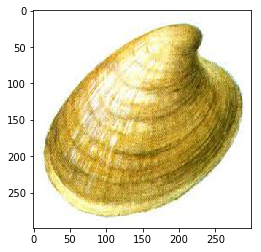

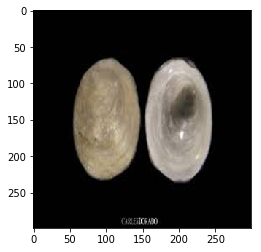

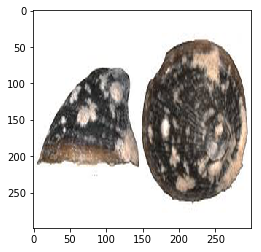

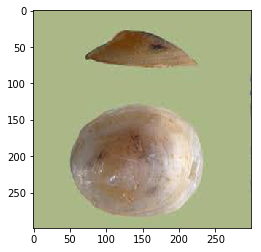

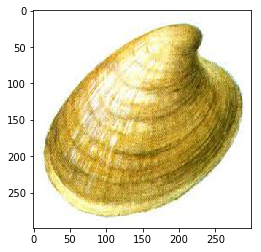

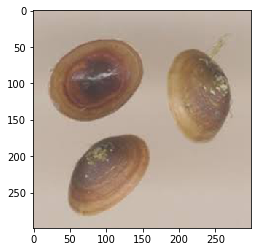

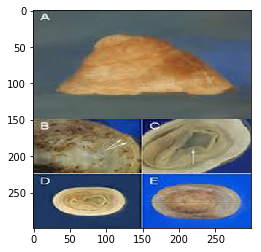

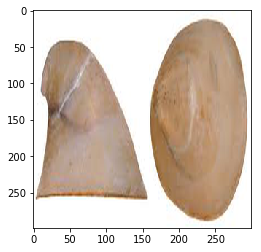

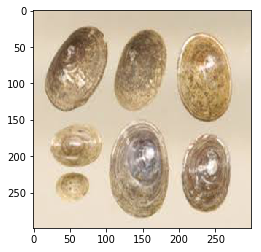

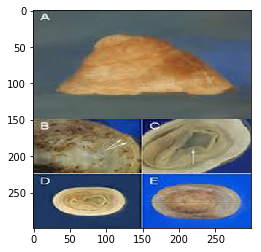

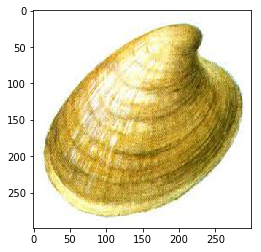

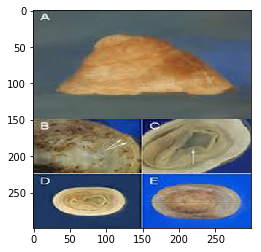

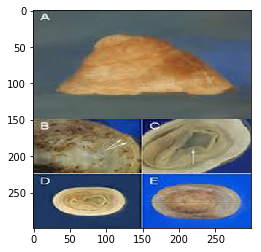

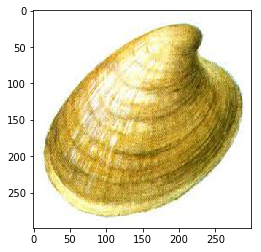

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
    
classes = ['ancylidae', 'thiaridae', 'lymnaeidae', 'corbiculidae', 'planorbidae', 'hydrobiidae', 'physidae', 'ampullariidae', 'neritidae', 'sphaeriidae']

X = X_validation
y = y_validation

decoded_y = np.array(
    [np.where(r==1)[0][0] for r in y])

for i in range(CLASSES):
    class_indices = np.squeeze([np.where(decoded_y == i)])
    
    batch_size = 32
    batch_class_indices = np.random.randint(0, class_indices.shape[0], (batch_size,))
    batch_indices = class_indices[batch_class_indices]
    #print(batch_indices)
    X_batch = X[batch_indices]
    y_batch = y[batch_indices]

    score = model.evaluate(X_batch, y_batch, batch_size=batch_size, verbose=0)
    
    print('Class: {} -----'.format(classes[i]))
    print("Acc: {}% Err: {} Top3: {}  Top5: {} ".format(score[2], score[0], score[3], score[4]))
    print("")
    
    if (score[3] < 0.7):
        for x in X_batch:
            x = np.expand_dims(x, axis=0)

            y_proba = model.predict(x)
            #print(y_proba)
            sorted_prob= sorted(enumerate(y_proba[0]), key=lambda z:z[1])
            y_classes = [i[0] for i in sorted_prob[::-1]]
            y_labels = [classes[i] for i in y_classes]


            #y_classes = y_proba.argmax(axis=-1)
            #print(y_labels[:3])            
            if not i in y_classes[:3]:
                print(sorted_prob)
                print(y_labels[:3])
                plt.figure()
                plt.imshow(x[0])

    
    #batch_indices = np.random.randint(0, X.shape[0], (batch_size,))

## Data Augmentation. Let's get crazy with this!!

In [13]:
import imgaug as ia
from imgaug import augmenters as iaa
#data augmentation

sometimes = lambda aug: iaa.Sometimes(0.5, aug)

augmenters = [
    # crop images by -5% to 10% of their height/width
    sometimes(iaa.CropAndPad(
        percent=(-0.05, 0.1),
        pad_mode=ia.ALL,
        pad_cval=(0, 255)
    )),
    
    sometimes(iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
        rotate=(-45, 45), # rotate by -45 to +45 degrees
        shear=(-16, 16), # shear by -16 to +16 degrees
        order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
        cval=(0, 255), # if mode is constant, use a cval between 0 and 255
        mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
    )),
    
    # execute 0 to 5 of the following (less important) augmenters per image
    # don't execute all of them, as that would often be way too strong
    iaa.SomeOf((0, 5),
        [
            sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
            
            iaa.OneOf([
                iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
            ]),
            
            iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
            
            iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
            
            # search either for all edges or for directed edges,
            # blend the result with the original image using a blobby mask
            iaa.SimplexNoiseAlpha(iaa.OneOf([
                iaa.EdgeDetect(alpha=(0.5, 1.0)),
                iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
            ])),
            
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
            
            iaa.OneOf([
                iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
            ]),
            
            iaa.Invert(0.05, per_channel=True), # invert color channels
            
            iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
            
            iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
            
            # either change the brightness of the whole image (sometimes
            # per channel) or change the brightness of subareas
            iaa.OneOf([
                iaa.Multiply((0.5, 1.5), per_channel=0.5),
                iaa.FrequencyNoiseAlpha(
                    exponent=(-4, 0),
                    first=iaa.Multiply((0.5, 1.5), per_channel=True),
                    second=iaa.ContrastNormalization((0.5, 2.0))
                )
            ]),
            
            iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
            
            iaa.Grayscale(alpha=(0.0, 1.0)),
            
            sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
            
            sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
            
            sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
        ],
        random_order=True
    )
]



augmenters = [
    
]
seq_no_flip = iaa.Sequential(augmenters,
    random_order=True)

augmenters.extend(
    [   
        iaa.Fliplr(0.5), # horizontally flip 50% of all images
        iaa.Flipud(0.2), # vertically flip 20% of all images
    ]
)
seq_with_flip = iaa.Sequential(augmenters,
    random_order=True)

seq = iaa.Sequential(
    [
        # apply the following augmenters to most images
        #iaa.Fliplr(0.5), # horizontally flip 50% of all images
        #iaa.Flipud(0.2), # vertically flip 20% of all images
        # crop images by -5% to 10% of their height/width
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,
            pad_cval=(0, 255)
        )),
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45), # rotate by -45 to +45 degrees
            shear=(-16, 16), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 255), # if mode is constant, use a cval between 0 and 255
            mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        )),
        # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                iaa.OneOf([
                    iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                    iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                ]),
                iaa.Invert(0.05, per_channel=True), # invert color channels
                iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                # either change the brightness of the whole image (sometimes
                # per channel) or change the brightness of subareas
                iaa.OneOf([
                    iaa.Multiply((0.5, 1.5), per_channel=0.5),
                    iaa.FrequencyNoiseAlpha(
                        exponent=(-4, 0),
                        first=iaa.Multiply((0.5, 1.5), per_channel=True),
                        second=iaa.ContrastNormalization((0.5, 2.0))
                    )
                ]),
                iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                iaa.Grayscale(alpha=(0.0, 1.0)),
                sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
            ],
            random_order=True
        )
    ],
    random_order=True
)

seq_val = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

/home/carlos/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


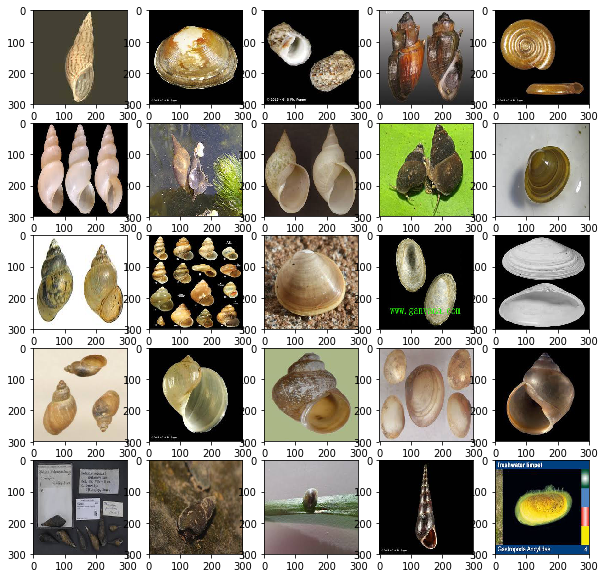

In [15]:
import math
from skimage import img_as_float
from skimage import img_as_ubyte

img = X_train[4]
image = img
pyplot.figure(figsize=(10, 10))

for i in range(25):
    pyplot.subplot(5,5,i+1)
    #i=189
    j = np.array(X_validation[i:i+1], dtype=float)
    j = img_as_ubyte(j)
    j = np.array(seq_no_flip.augment_images(list(j)))
    j = img_as_float(j)
    
    pyplot.imshow(j[0], cmap=pyplot.get_cmap('gray'))

pyplot.show()

In [24]:
#model.set_weights(Wsave)

from skimage import img_as_float
from skimage import img_as_ubyte

NB_IMAGES = 1000
NB_BATCHES = 1000
BATCH_SIZE = 128


import time



def batch_generator(X, y, batch_size, seq=None):
    
    start = time.time()
    
    
    
    # collect randomly chosen images with their labels for the batch
    batch_indices = np.random.randint(0, X.shape[0], (batch_size,))

    X_batch = np.array(X[batch_indices])
    y_batch = np.array(y[batch_indices])
    
    
    #class filtering
    decoded_y = np.array([np.where(r==1)[0][0] for r in y_batch])     
    X_augmented_batch = []
    y_augmented_batch = []
    
    for i in range(CLASSES):
        class_indices = np.squeeze([np.where(decoded_y == i)])

        X_batch_class = X_batch[class_indices]
        y_batch_class = y_batch[class_indices]

        if seq:
            X_batch_class = img_as_ubyte(X_batch_class)
            X_batch_class = seq[i].augment_images(X_batch_class)
            X_batch_class = img_as_float(X_batch_class)
        
        X_augmented_batch.extend(X_batch_class)
        y_augmented_batch.extend(y_batch_class)

    aux_batch = list(zip(X_augmented_batch, y_augmented_batch))
    shuffle(aux_batch)
    
    X_augmented_batch, y_augmented_batch = zip(*aux_batch)

    X_augmented_batch = np.array(X_augmented_batch)
    y_augmented_batch = np.array(y_augmented_batch)
    
    
    end = time.time()
    print('batch_generator: {:f}s'.format(end - start))
    return (X_augmented_batch, y_augmented_batch)
    
    
seq_per_class = [seq, seq, seq, seq, seq, seq, seq, seq, seq, seq]
# train in a loop on 1k batches
for batch_idx in range(NB_BATCHES):
    #X,y = batch_generator(X_train, y_train, BATCH_SIZE, seq)
    
    X,y = batch_generator(X_train, y_train, BATCH_SIZE, seq_per_class)
    temp = model.train_on_batch (X, y)
    print('train batch:%d/%d, loss:%.6f, acc:%6f'%(batch_idx * BATCH_SIZE, BATCH_SIZE*NB_BATCHES, temp[0], temp[1]))
    print(temp)
    print('')
    
    if batch_idx % 10 == 0:
        X,y = batch_generator(X_validation, y_validation, 64)
        temp = model.test_on_batch(X,y)
        print('validation batch:%d/%d, loss:%.6f, acc:%6f'%(batch_idx * 64, 64*NB_BATCHES//10, temp[0], temp[1]))
        print(temp)
        
        print('')
    
    


/home/carlos/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


batch_generator: 6.923677s
train batch:0/128000, loss:1.297727, acc:0.546933
[1.297727, 0.54693347, 0.59375, 0.8671875, 0.9609375]

batch_generator: 0.188837s
validation batch:0/6400, loss:1.156451, acc:0.582835
[1.1564512, 0.58283544, 0.625, 0.828125, 0.921875]

batch_generator: 3.471045s
train batch:128/128000, loss:1.342546, acc:0.490487
[1.3425456, 0.49048713, 0.5390625, 0.8046875, 0.9296875]

batch_generator: 5.603163s
train batch:256/128000, loss:1.289956, acc:0.575729
[1.2899559, 0.57572889, 0.6171875, 0.828125, 0.921875]



KeyboardInterrupt: 

In [ ]:
from skimage import data, img_as_float
from skimage import exposure, color, filters

import warnings

   
def blurring(x, min_blur=0, max_blur=0, alpha=None,):
    if not alpha:
        alpha = np.random.uniform(min_blur, max_blur)
    
    if np.shape(x)[2] == 1:
        x = filters.gaussian(x, sigma=alpha, multichannel = None)

    elif np.shape(x)[2] == 3:
        x = filters.gaussian(x, sigma=alpha, multichannel = False)

    else:
        warnings.warn('Improper Image Size - Expected Format - ?,?,1 or 3')
        
    return x

def adaptive_equalization(x, limit = 0.03):
    if np.shape(x)[2] == 1:
        x = exposure.equalize_adapthist(x, clip_limit=limit, nbins=48)

    elif np.shape(x)[2] == 3:
        x = img_as_float(x)
        img_hsv = color.rgb2hsv(x)
        brightness = img_hsv[:,:,2]

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            b_adapteq = exposure.equalize_adapthist(
                brightness,
                clip_limit=limit,
                nbins=48)

        img_hsv[:,:,2] = b_adapteq
        x = color.hsv2rgb(img_hsv)

    else:
        warnings.warn('Improper Image Size - Expected Format - ?,?,1 or 3') 
    
    return x

def contrast_stretching(x, p_ini = 2, p_fin = 98):
    pi, pf = np.percentile(x, (p_ini, p_fin))
    x = exposure.rescale_intensity(x, in_range=(pi, pf))
    return x

def histogram_equalization(x, *args):
    x = exposure.equalize_hist(x, 2048)
    return x

# img bright
def random_bright(x, alpha=None, illumin_limit = 0.5):
    if not alpha:
        alpha = 1.0 + illumin_limit*np.random.uniform(-1, 1)
    
    img_bright = np.clip(x * alpha, 0., 1.)
    return img_bright

def random_contrast(x, alpha=None, illumin_limit=0.5):
    if not alpha:
        alpha = 1.0 + illumin_limit*np.random.uniform(-1, 1)
        
    coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B
    gray = x * coef
    gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
    
    img_contrast = x * alpha + gray
    img_contrast = np.clip(img_contrast,0.,1.)
    return img_contrast


def random_saturation(x, alpha=None, illumin_limit=0.5):
    if not alpha:
        alpha = 1.0 + illumin_limit*np.random.uniform(-1, 1)
        
    coef = np.array([[[0.299, 0.587, 0.114]]]) #rgb to gray (YCbCr) :  Y = 0.299R + 0.587G + 0.114B
    gray = x * coef
    gray = np.sum(gray, axis=2, keepdims=True)
    gray *= (1.0 - alpha)
    
    img_saturation = x * alpha + gray
    img_saturation = np.clip(img_saturation,0.,1.)
    return img_saturation


def random_activator(x, alpha, fun, *args):
    if not alpha:
        alpha = 0
    if np.random.random() < alpha:
        return fun(x, *args)
    return x

def random_normalization(x):
    if np.random.random() < 0.5:
        return adaptive_equalization(x, 0.03)
    else:
        return contrast_stretching(x, 2,98)

def random_bcs(x):
    x = random_bright(x)
    x = random_contrast(x)
    x = random_saturation(x)
    return x



In [ ]:
img = X_train[4]
image = img
pyplot.figure(figsize=(10, 10))
print(y_train.sum(axis=0))

for i in range(25):
    pyplot.subplot(5,5,i+1)
    j =  X_train[i]
    print(y_train[i])
    pyplot.imshow(random_bright(j, 1 + 1.0/25*i*0), cmap=pyplot.get_cmap('gray'))

# show the plot
#pyplot.show()


pyplot.figure(figsize=(10, 10))
for i in range(25):
    pyplot.subplot(5,5,i+1)
    pyplot.imshow(random_contrast(image, 0.5 + 1.0/25*i), cmap=pyplot.get_cmap('gray'))

# show the plot
#pyplot.show()


pyplot.figure(figsize=(10, 10))
for i in range(25):
    pyplot.subplot(5,5,i+1)
    pyplot.imshow(random_saturation(image, 0.5 + 1.0/25*i), cmap=pyplot.get_cmap('gray'))

    
pyplot.figure(figsize=(15, 15))
for i in range(25):
    pyplot.subplot(5,5,i+1)
    pyplot.imshow(blurring(image, alpha=1.3/25*i), cmap=pyplot.get_cmap('gray'))
# show the plot
pyplot.show()

In [ ]:
image = img
pyplot.figure(figsize=(9, 9))

for i in range(25):
    pyplot.subplot(5,5,i+1)
    x = random_bright(image)
    x = random_contrast(x)
    x = random_saturation(x)
    pyplot.imshow(x, cmap=pyplot.get_cmap('gray'))

# show the plot
pyplot.show()

In [ ]:
%matplotlib inline
class ImageDataGenerator_dev(ImageDataGenerator):
    def __init__(self,
        custom_std_functions=0,
        custom_rdm_functions=0,
        *args, **kwargs):
        
        print('Custom ImageDataGenerator')
        super(ImageDataGenerator_dev, self).__init__(*args, **kwargs)
        self.custom_std_functions=custom_std_functions
        self.custom_rdm_functions=custom_rdm_functions
      
    def standardize(self, *args, **kwargs):
        x = super(ImageDataGenerator_dev, self).standardize(*args, **kwargs)

        if self.custom_std_functions:
            for task in self.custom_std_functions:
                #print(task.fun)
                x = task.fun(x, *task.args)
        return x
        
        
    def random_transform(self, 
        *args, **kwargs):
        
        #import Image
        '''
        formatted = (args[0] * 255 / np.max(args[0])).astype('uint8')
        %matplotlib inline
        import skimage
        from skimage import data
        from matplotlib import pyplot as plt
        %pylab inline

        img = formatted
        pyplot.figure(figsize=(2, 2))
        plt.imshow(img,cmap='gray')
        plt.show()
        '''
        x = super(ImageDataGenerator_dev, self).random_transform(*args, **kwargs)
        if self.custom_rdm_functions:
            for task in self.custom_rdm_functions:
                x = task.fun(x, *task.args)
        return x
    
class Task:
    def __init__(self, fun, *args):
        self.fun = fun
        self.args = args

# define data preparation
datagen = ImageDataGenerator_dev(  
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    #fill_mode='nearest',
    
    #custom_rdm_functions=[              
    #],
    custom_std_functions=[
        Task(random_activator, 0.2, random_normalization),
        Task(random_activator, 0.8, random_bcs),
        Task(random_activator, 0.5, blurring, 0, 1.3),
    ]
)


# fit parameters from data
datagen.fit(X_train)
# configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    pyplot.figure(figsize=(12, 12))
    for i in range(0, 9):
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(X_batch[i], cmap=pyplot.get_cmap('gray'))
        print(y_batch[i])
        
    # show the plot
    pyplot.show()
    break

In [ ]:
class_length = y_train.sum(axis=0)

#[ np.where(r==1)[0][0] for r in y_train ]

In [ ]:
directory = './preview/'
# Create path for dataset if not existing
if not os.path.exists(os.path.dirname(directory)):
    try:
        os.makedirs(os.path.dirname(directory))
    except OSError as exc:  # Guard against race condition
        if exc.errno != errno.EEXIST:
            raise

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(X_train, y_train, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    print(batch[1][0])
    #break
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
        


In [ ]:
batch_size = 16

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        'data/train',  # this is the target directory
        target_size=(DIM, DIM),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        'data/validation',
        target_size=(DIM, DIM),
        batch_size=batch_size,
        class_mode='categorical')

In [ ]:
model.compile(optimizer='nadam',
             loss='categorical_crossentropy',
             metrics=['accuracy'])


In [ ]:
import matplotlib.pyplot as plt
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')

    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.show()


In [ ]:
# let's visualize layer names and layer indices to see how many layers
# we should freeze:
#for i, layer in enumerate(base_model.layers):
#    print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

from datetime import datetime
now = datetime.now()
logdir = "./tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_images=True)

model_path = './models'
top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
callbacks_list = [
    tbCallBack,    
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=5, verbose=0)       
]

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history_ft = model.fit_generator(
        train_generator,
        #steps_per_epoch=2000 // batch_size,
        steps_per_epoch=16*2,
        epochs=10,
        validation_data=validation_generator,
        #validation_steps=800 // batch_size,
        validation_steps=50,
        callbacks = callbacks_list)

plot_training(history_ft)

In [ ]:
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint, EarlyStopping
import os

from datetime import datetime
now = datetime.now()
logdir = "./tf_logs/" + now.strftime("%Y%m%d-%H%M%S") + "/"

tbCallBack = TensorBoard(log_dir=logdir, histogram_freq=0, write_graph=True, write_images=True)

model_path = './models'
top_weights_path = os.path.join(os.path.abspath(model_path), 'top_model_weights.h5')
callbacks_list = [
    tbCallBack,    
    ModelCheckpoint(top_weights_path, monitor='val_acc', verbose=1, save_best_only=True),
    EarlyStopping(monitor='val_acc', patience=5, verbose=0)       
]


history_ft = model.fit_generator(
        train_generator,
        #steps_per_epoch=2000 // batch_size,
        steps_per_epoch=16*2,
        epochs=10,
        validation_data=validation_generator,
        #validation_steps=800 // batch_size,
        validation_steps=50,
        callbacks = callbacks_list)

plot_training(history_ft)


In [ ]:
model.load_weights('./models/top_model_weights.h5')
model.evaluate_generator(validation_generator, 40)

In [ ]:
from keras.preprocessing import image
import numpy as np

label_map = ['Calopterygidae', 'Heptageniidae']


img = image.load_img('/home/carlos/Dropbox/Reconocimiento Automático/Calopterygidae/DMS10089.JPG',
#img = image.load_img('/home/carlos/Dropbox/Reconocimiento Automático/Heptageniidae/DMS10132.JPG',
                    target_size=(DIM,DIM))
x = image.img_to_array(img)
x /=255
x = np.expand_dims(x, axis=0)


images = np.vstack([x])

classes = model.predict(images)
print(label_map)
print(classes)


In [ ]:
# this is a similar generator, for validation data
test_generator = test_datagen.flow_from_directory(
        'data/test',
        target_size=(DIM, DIM),
        batch_size=batch_size,
        class_mode='categorical')

model.evaluate_generator(test_generator, 34)
